# Spurious Edge Detection: Pseudo-Self-Loop Filtering

**Problem**: Entity linker misattributes self-mentions to family members with shared surnames (e.g., "Darwin" → George Darwin instead of Charles Darwin). Standard self-loop filters miss these.

**Detection**: Combined filter requiring BOTH conditions:
1. Shared name components between source and target
2. Statistical outlier weight (z-score > threshold) relative to source node distribution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src import filters

## 1. Load Data

In [2]:
INPUT_DATASET = '../data/out/SpotlightWeightSource_1210_0303.csv'

edges = pd.read_csv(INPUT_DATASET)
edges = edges.rename(columns={'weight': 'nij', 'source_wikidata_id': 'src', 'target_wikidata_id': 'tgt'})
edges = edges[edges['src'] != edges['tgt']]  # Remove self-loops
edges = edges[edges['nij'] > 0]  # Remove zero weights

print(f"Total edges: {len(edges):,}")
edges.head()

Total edges: 2,837,458


,language_code,src,tgt,nij
2,es,Q455209,Q229279,1.0
8,fr,Q129079,Q130531,1.0
15,en,Q1279339,Q311814,1.0
19,en,Q237642,Q359014,1.0
25,fr,Q68409,Q41508,1.0


In [3]:
print("Weight Distribution:")
print(edges['nij'].describe())
print(f"95th percentile: {edges['nij'].quantile(0.95):.2f}")
print(f"99th percentile: {edges['nij'].quantile(0.99):.2f}")

Weight Distribution:
count    2.837458e+06
mean     1.645726e+00
std      2.560075e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.650000e+02
Name: nij, dtype: float64
95th percentile: 4.00
99th percentile: 10.00


## 2. Enrich Edges with English Titles

In [4]:
from src.modules.duckdb_handler import DuckDBHandler

db = DuckDBHandler('/home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/graph_final.db')

# Drop existing title columns if present
title_cols = ['src_title', 'trg_title', 'src_title_x', 'trg_title_x', 'src_title_y', 'trg_title_y']
edges = edges.drop(columns=[col for col in title_cols if col in edges.columns])

# Get unique QIDs
qid_list = pd.unique(edges[['src', 'tgt']].values.ravel('K'))
qid_list = [str(qid) for qid in qid_list if pd.notna(qid)]

print(f"Retrieving titles for {len(qid_list):,} QIDs...")

# Retrieve and merge titles
titles_df = db.get_titles_for_qids_english(qid_list=qid_list, language_code='en')

edges = edges.merge(
    titles_df.rename(columns={'qid': 'src', 'title': 'src_title'}),
    on='src', how='left'
)
edges = edges.merge(
    titles_df.rename(columns={'qid': 'tgt', 'title': 'trg_title'}),
    on='tgt', how='left'
)

db.close()

print(f"Edges with both titles: {(edges['src_title'].notna() & edges['trg_title'].notna()).sum():,}")
display(edges[['src', 'src_title', 'tgt', 'trg_title', 'nij']].head(10))

Retrieving titles for 92,199 QIDs...
Edges with both titles: 2,836,180


,src,src_title,tgt,trg_title,nij
0,Q455209,"Anne Seymour, Duchess of Somerset",Q229279,Philippa of Hainault,1.0
1,Q129079,Paul Verhoeven,Q130531,Hieronymus Bosch,1.0
2,Q1279339,John Collins (mathematician),Q311814,Giovanni Alfonso Borelli,1.0
3,Q237642,Laodice III,Q359014,Mithridates II of Pontus,1.0
4,Q68409,Walter Peterhans,Q41508,Ludwig Mies van der Rohe,1.0
5,Q17612464,Jihadi John,Q17573849,Steven Sotloff,4.0
6,Q133903,Virgil van Dijk,Q219248,Marc Overmars,1.0
7,Q133903,Virgil van Dijk,Q745056,Kris Commons,2.0
8,Q133903,Virgil van Dijk,Q2896171,Benjamin Mendy,1.0
9,Q253458,Aristyllus,Q180671,Aratus,1.0


## 3. High-Weight Edges Exploration

In [5]:
top_edges = edges.nlargest(50, 'nij')

print("Top 50 highest-weight edges:")
display_cols = ['src', 'src_title', 'tgt', 'trg_title', 'nij'] if 'src_title' in edges.columns else ['src', 'tgt', 'nij']
display(top_edges[display_cols])

Top 50 highest-weight edges:


,src,src_title,tgt,trg_title,nij
832605,Q150611,"Ferdinand I, Holy Roman Emperor",Q313426,"Ferdinand II, Archduke of Austria",965.0
2595881,Q314252,Gregory Bateson,Q297302,William Bateson,394.0
1696574,Q1541,Cicero,Q316054,Quintus Tullius Cicero,313.0
538082,Q191014,Isabel Perón,Q93330,Juan Perón,306.0
1706509,Q7721,Napoleon III,Q517,Napoleon,306.0
292827,Q186709,Nikolai Bukharin,Q1394,Vladimir Lenin,300.0
1482109,Q213122,Betty Ford,Q9582,Gerald Ford,292.0
998159,Q57177,Wolfram von Richthofen,Q4701,Manfred von Richthofen,291.0
944859,Q47152,Mary Shelley,Q93343,Percy Bysshe Shelley,290.0
2200005,Q529207,Ronaldo (Brazilian footballer),Q11571,Cristiano Ronaldo,275.0


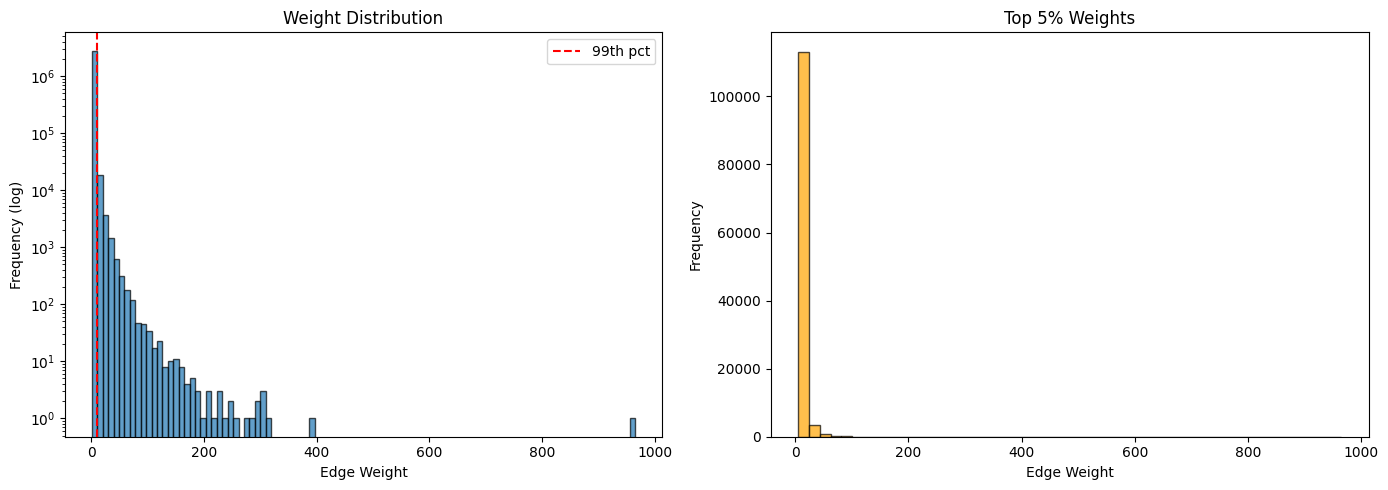

Edges with weight > 100: 135


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
axes[0].hist(edges['nij'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_yscale('log')
axes[0].set_xlabel('Edge Weight')
axes[0].set_ylabel('Frequency (log)')
axes[0].set_title('Weight Distribution')
axes[0].axvline(edges['nij'].quantile(0.99), color='red', linestyle='--', label='99th pct')
axes[0].legend()

# Top 5% only
high_weights = edges[edges['nij'] > edges['nij'].quantile(0.95)]
axes[1].hist(high_weights['nij'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Edge Weight')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top 5% Weights')

plt.tight_layout()
plt.show()

print(f"Edges with weight > 100: {len(edges[edges['nij'] > 100]):,}")

## 4. Absolute Threshold (Baseline)

Exclude edges with weight ≥ 100. Crude, context-unaware baseline.

In [7]:
filter_weight_100 = filters.exclude_high_weight_edges(max_weight=100)
edges['keep_absolute'] = edges.apply(filter_weight_100, axis=1)

print(f"Excluded: {(~edges['keep_absolute']).sum():,} ({100*(~edges['keep_absolute']).sum()/len(edges):.2f}%)")

excluded = edges[~edges['keep_absolute']]
if len(excluded) > 0:
    print(f"\nTop 20 excluded edges:")
    sample_cols = ['src_title', 'trg_title', 'nij'] if 'src_title' in edges.columns else ['src', 'tgt', 'nij']
    display(excluded.nlargest(20, 'nij')[sample_cols])

Excluded: 142 (0.01%)

Top 20 excluded edges:


,src_title,trg_title,nij
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0
2595881,Gregory Bateson,William Bateson,394.0
1696574,Cicero,Quintus Tullius Cicero,313.0
538082,Isabel Perón,Juan Perón,306.0
1706509,Napoleon III,Napoleon,306.0
292827,Nikolai Bukharin,Vladimir Lenin,300.0
1482109,Betty Ford,Gerald Ford,292.0
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0
944859,Mary Shelley,Percy Bysshe Shelley,290.0
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0


## 5. Title Matching

Test if shared-name edges correlate with high weights.

In [8]:
has_titles = 'src_title' in edges.columns and 'trg_title' in edges.columns

if has_titles:
    print(f"Source titles: {edges['src_title'].notna().sum():,} / {len(edges):,}")
    print(f"Target titles: {edges['trg_title'].notna().sum():,} / {len(edges):,}")
else:
    print("Title columns not found. Run enrichment first.")

Source titles: 2,836,526 / 2,837,458
Target titles: 2,837,031 / 2,837,458


In [9]:
if has_titles:
    filter_shared_names = filters.exclude_edges_with_shared_names()
    edges['keep_title_filter'] = edges.apply(filter_shared_names, axis=1)
    edges['has_shared_name'] = ~edges['keep_title_filter']
    
    print(f"Edges with shared names: {edges['has_shared_name'].sum():,} ({100*edges['has_shared_name'].mean():.2f}%)")
    
    high_weight = edges[edges['nij'] > edges['nij'].quantile(0.95)]
    print(f"Among top 5% weights: {100*high_weight['has_shared_name'].mean():.1f}% have shared names")
    
    print("\nTop 10 shared-name edges with high weight:")
    examples = edges[edges['has_shared_name'] & (edges['nij'] > 50)].nlargest(10, 'nij')
    display(examples[['src_title', 'trg_title', 'nij']])
    
    print("\n20 random shared-name edges:")
    excluded = edges[~edges['keep_title_filter']]
    if len(excluded) > 0:
        display(excluded.sample(min(20, len(excluded)))[['src_title', 'trg_title', 'nij']])
else:
    print("Skipping - enrich data first")

Edges with shared names: 107,193 (3.78%)
Among top 5% weights: 9.0% have shared names

Top 10 shared-name edges with high weight:


,src_title,trg_title,nij
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0
2595881,Gregory Bateson,William Bateson,394.0
1696574,Cicero,Quintus Tullius Cicero,313.0
538082,Isabel Perón,Juan Perón,306.0
1706509,Napoleon III,Napoleon,306.0
1482109,Betty Ford,Gerald Ford,292.0
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0
944859,Mary Shelley,Percy Bysshe Shelley,290.0
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0



20 random shared-name edges:


,src_title,trg_title,nij
342499,Max Liebermann,Max Pechstein,3.0
1782563,Juliana Maria of Brunswick-Wolfenbüttel,"Ferdinand Albert II, Duke of Brunswick-Wolfenb...",1.0
2771170,Marie Bonaparte,Joseph Bonaparte,1.0
412481,Wilhelm Emmanuel von Ketteler,Clemens August Graf von Galen,1.0
1012504,Juancho Hernangómez,Willy Hernangómez,4.0
2099466,Rajiv Gandhi,Indira Gandhi,1.0
816312,Hedwig Eleonora of Holstein-Gottorp,"Adolf, Duke of Holstein-Gottorp",1.0
1536707,William Wilberforce,William Cobbett,1.0
1142075,Henri de Toulouse-Lautrec,Henry de Groux,1.0
1709,"Louis Charles, Count of Eu",Louis XV,5.0


## 6. Relative Weight (Per-Node Outlier Detection)

Z-score based outlier detection. Edge weight compared to source node's distribution.

In [10]:
node_stats = edges.groupby('src')['nij'].agg(['mean', 'std', 'count']).reset_index()
node_stats.columns = ['src', 'mean_weight', 'std_weight', 'edge_count']

edges = edges.merge(node_stats, on='src', how='left')
edges['z_score'] = (edges['nij'] - edges['mean_weight']) / edges['std_weight']
edges['z_score'] = edges['z_score'].fillna(0)

print("Per-node statistics:")
print(node_stats.describe())

Per-node statistics:
        mean_weight    std_weight    edge_count
count  90626.000000  87735.000000  90626.000000
mean       1.457562      1.008664     31.309536
std        0.664611      1.545581     42.595468
min        1.000000      0.000000      1.000000
25%        1.048780      0.267261      8.000000
50%        1.255089      0.581121     18.000000
75%        1.600000      1.194370     37.000000
max       16.500000     68.126501    775.000000


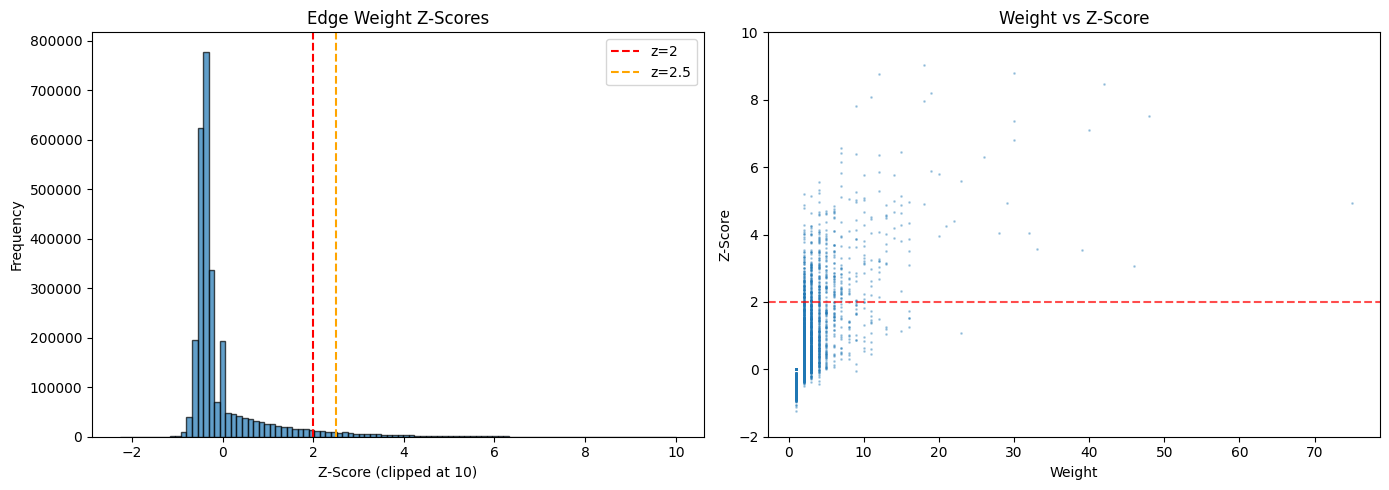

Edges with z > 2: 146,585 (5.17%)


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Z-score histogram
axes[0].hist(edges['z_score'].clip(-5, 10), bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(2, color='red', linestyle='--', label='z=2')
axes[0].axvline(2.5, color='orange', linestyle='--', label='z=2.5')
axes[0].set_xlabel('Z-Score (clipped at 10)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Edge Weight Z-Scores')
axes[0].legend()

# Weight vs z-score
sample = edges.sample(min(10000, len(edges)))
axes[1].scatter(sample['nij'], sample['z_score'], alpha=0.3, s=1)
axes[1].axhline(2, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('Z-Score')
axes[1].set_title('Weight vs Z-Score')
axes[1].set_ylim(-2, 10)

plt.tight_layout()
plt.show()

print(f"Edges with z > 2: {(edges['z_score'] > 2).sum():,} ({100*(edges['z_score'] > 2).mean():.2f}%)")

In [12]:
edges_for_filter = edges[['src', 'tgt', 'nij']].rename(columns={'src': 'source', 'tgt': 'target'})

filter_relative = filters.exclude_edges_with_relative_high_weight(
    edges_df=edges_for_filter,
    std_threshold=2.0,
    min_edges_for_stats=5
)

edges['keep_relative'] = edges_for_filter.apply(filter_relative, axis=1)

print(f"Excluded: {(~edges['keep_relative']).sum():,} ({100*(~edges['keep_relative']).sum()/len(edges):.2f}%)")

excluded = edges[~edges['keep_relative']]
if len(excluded) > 0:
    print(f"\nTop 30 excluded by z-score:")
    sample_cols = ['src_title', 'trg_title', 'nij', 'z_score'] if 'src_title' in edges.columns else ['src', 'tgt', 'nij', 'z_score']
    display(excluded.nlargest(30, 'z_score')[sample_cols])

Excluded: 150,665 (5.31%)

Top 30 excluded by z-score:


,src_title,trg_title,nij,z_score
1748261,Pope Francis,Francis of Assisi,164.0,20.781768
2653801,Elton John,John Lennon,164.0,20.348882
337352,Venus Williams,Serena Williams,93.0,19.731038
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
893486,Johann Sebastian Bach,Carl Philipp Emanuel Bach,146.0,18.143089
684557,Cristiano Ronaldo,Ronaldo (Brazilian footballer),176.0,17.974417
79274,Catherine Deneuve,Catherine the Great,67.0,17.268309
742224,Novak Djokovic,Rafael Nadal,209.0,16.557621
1180801,John Wayne,John Ford,53.0,16.115626
1797465,Roger Federer,Rafael Nadal,151.0,15.964778


## 7. Combined Filter: Title Match AND Relative Weight

AND logic: exclude only if shared name AND z-score > threshold. Targets pseudo-self-loops.

In [13]:
if has_titles:
    edges['keep_combined'] = edges['keep_title_filter'] | edges['keep_relative']
    edges['excluded_by_both'] = edges['has_shared_name'] & (~edges['keep_relative'])
    
    print("Filter Comparison:")
    print(f"Absolute (weight < 100): {(~edges['keep_absolute']).sum():,} excluded")
    print(f"Title matching only: {(~edges['keep_title_filter']).sum():,} excluded")
    print(f"Relative weight (z > 2): {(~edges['keep_relative']).sum():,} excluded")
    print(f"Combined (BOTH): {edges['excluded_by_both'].sum():,} excluded")
    
    pseudo_self_loops = edges[edges['excluded_by_both']]
    
    if len(pseudo_self_loops) > 0:
        print(f"\nPseudo-self-loops: {len(pseudo_self_loops):,}")
        print("\nTop 20 by weight:")
        display(pseudo_self_loops.nlargest(20, 'nij')[['src_title', 'trg_title', 'nij', 'z_score']])
        
        if len(pseudo_self_loops) > 20:
            print(f"\n20 random from remaining {len(pseudo_self_loops) - 20}:")
            remaining = pseudo_self_loops.nsmallest(len(pseudo_self_loops) - 20, 'nij')
            display(remaining.sample(min(20, len(remaining)))[['src_title', 'trg_title', 'nij', 'z_score']])
else:
    print("Cannot demo combined approach without titles")

Filter Comparison:
Absolute (weight < 100): 142 excluded
Title matching only: 107,193 excluded
Relative weight (z > 2): 150,665 excluded
Combined (BOTH): 9,888 excluded

Pseudo-self-loops: 9,888

Top 20 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random from remaining 9868:


,src_title,trg_title,nij,z_score
1712721,Quintus Servilius Caepio (consul 106 BC),Marcus Aemilius Scaurus (consul 115 BC),5.0,2.215175
1442839,Peter Medak,Peter Sellers,3.0,5.102520
1086128,Tamar Braxton,Toni Braxton,13.0,6.996744
409309,"Pedro Nuño Colón de Portugal, 6th Duke of Veragua",Antonio de Mendoza,2.0,2.561738
2384770,Henry II of Cyprus,Hugh IV of Cyprus,14.0,4.780914
1124785,Victoria Beckham,David Beckham,7.0,2.022528
669596,Ferdinand I of Bulgaria,Boris III of Bulgaria,3.0,2.873330
1561662,David Blu,David Blatt,2.0,2.666667
1024008,John McCarthy (computer scientist),John Searle,2.0,2.022600
104015,Larry Bishop,Joey Bishop,2.0,2.072548


Total edges: 2,837,458
Shared names only: 97,305
High z-score only: 140,777
BOTH (pseudo-self-loops): 9,888 ⚠️
Neither (clean): 2,589,488 ✓


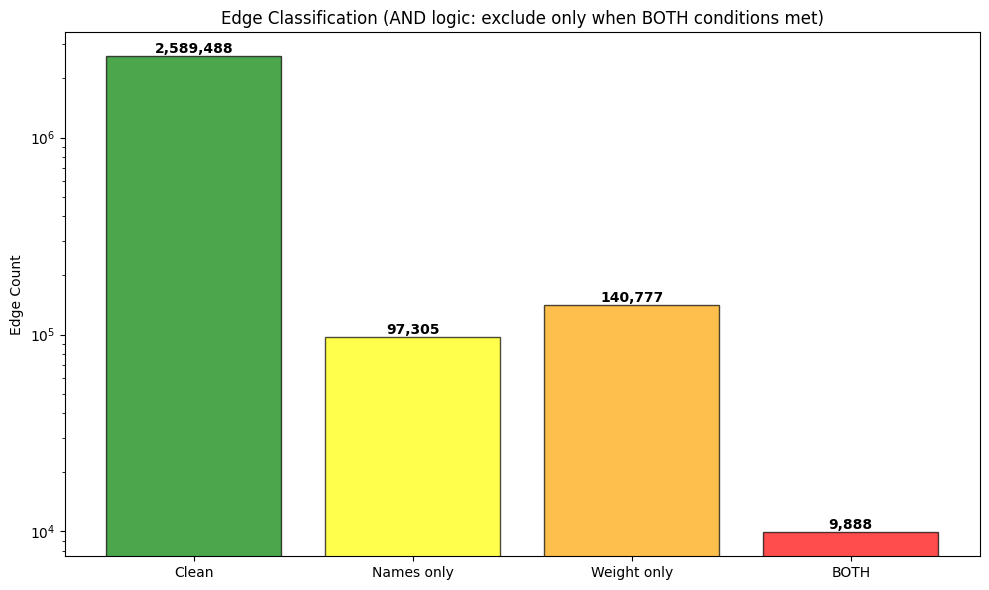

In [14]:
if has_titles:
    only_title = edges['has_shared_name'] & edges['keep_relative']
    only_relative = (~edges['has_shared_name']) & (~edges['keep_relative'])
    both_criteria = edges['has_shared_name'] & (~edges['keep_relative'])
    neither = (~edges['has_shared_name']) & edges['keep_relative']
    
    print(f"Total edges: {len(edges):,}")
    print(f"Shared names only: {only_title.sum():,}")
    print(f"High z-score only: {only_relative.sum():,}")
    print(f"BOTH (pseudo-self-loops): {both_criteria.sum():,} ⚠️")
    print(f"Neither (clean): {neither.sum():,} ✓")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = ['Clean', 'Names only', 'Weight only', 'BOTH']
    counts = [neither.sum(), only_title.sum(), only_relative.sum(), both_criteria.sum()]
    colors = ['green', 'yellow', 'orange', 'red']
    
    bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Edge Count')
    ax.set_title('Edge Classification (AND logic: exclude only when BOTH conditions met)')
    ax.set_yscale('log')
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{count:,}',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Need titles for visualization")

## 8. Parameter Tuning

Adjust the z-score threshold to find the sweet spot for your data.

Threshold tuning:


,threshold,excluded_count,excluded_pct
0,1.5,211845,7.466014
1,2.0,150665,5.309858
2,2.5,104265,3.674592
3,3.0,72023,2.538293


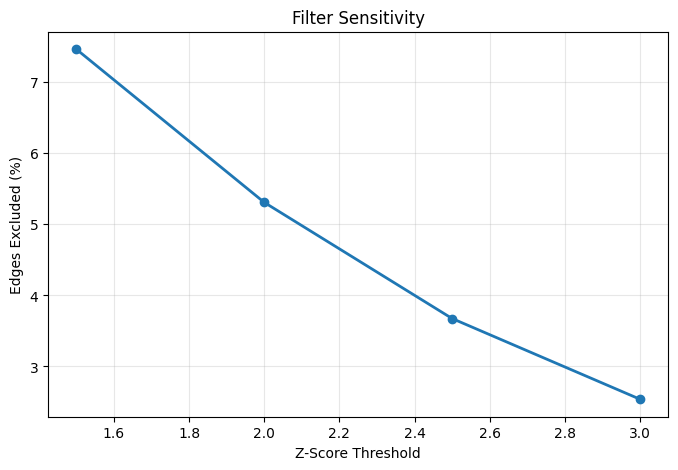

In [15]:
thresholds = [1.5, 2.0, 2.5, 3.0]

results = []
for thresh in thresholds:
    edges_temp = edges[['src', 'tgt', 'nij']].rename(columns={'src': 'source', 'tgt': 'target'})
    
    filter_z = filters.exclude_edges_with_relative_high_weight(
        edges_df=edges_temp, std_threshold=thresh, min_edges_for_stats=5
    )
    
    keep = edges_temp.apply(filter_z, axis=1)
    excluded = (~keep).sum()
    
    results.append({
        'threshold': thresh,
        'excluded_count': excluded,
        'excluded_pct': 100 * excluded / len(edges)
    })

results_df = pd.DataFrame(results)
print("Threshold tuning:")
display(results_df)

plt.figure(figsize=(8, 5))
plt.plot(results_df['threshold'], results_df['excluded_pct'], marker='o', linewidth=2)
plt.xlabel('Z-Score Threshold')
plt.ylabel('Edges Excluded (%)')
plt.title('Filter Sensitivity')
plt.grid(True, alpha=0.3)
plt.show()

### Manual Verification

Examine combined filter results across thresholds.

In [16]:
for thresh in thresholds:
    print(f"\n{'='*80}\nZ-SCORE THRESHOLD: {thresh}\n{'='*80}")
    
    edges_temp = edges[['src', 'tgt', 'nij']].rename(columns={'src': 'source', 'tgt': 'target'})
    filter_z = filters.exclude_edges_with_relative_high_weight(
        edges_df=edges_temp, std_threshold=thresh, min_edges_for_stats=5
    )
    keep_z = edges_temp.apply(filter_z, axis=1)
    
    if has_titles:
        excluded_combined = edges[edges['has_shared_name'] & (~keep_z)]
        
        print(f"Excluded: {len(excluded_combined):,} ({100*len(excluded_combined)/len(edges):.2f}%)")
        
        if len(excluded_combined) > 0:
            print("\nTop 10 by weight:")
            display(excluded_combined.nlargest(10, 'nij')[['src_title', 'trg_title', 'nij', 'z_score']])
            
            if len(excluded_combined) > 10:
                print(f"\n20 random samples:")
                n_samples = min(20, len(excluded_combined))
                display(excluded_combined.sample(n_samples)[['src_title', 'trg_title', 'nij', 'z_score']].sort_values('nij', ascending=False))
        else:
            print("✓ No pseudo-self-loops at this threshold")
    else:
        print("⚠️ Titles required")


Z-SCORE THRESHOLD: 1.5
Excluded: 13,019 (0.46%)

Top 10 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random samples:


,src_title,trg_title,nij,z_score
1025016,Dana International,Dana Rosemary Scallon,43.0,5.378376
2483779,Johann Strauss II,Richard Strauss,36.0,7.192905
2770994,Isambard Kingdom Brunel,Marc Isambard Brunel,19.0,5.364852
221333,Khalid of Saudi Arabia,Fahd of Saudi Arabia,18.0,2.601163
2242805,Manuel I Komnenos,John II Komnenos,13.0,3.608553
2686107,"Edward of Middleham, Prince of Wales",Edward V,10.0,3.287659
2340360,Mario Donizetti,Gaetano Donizetti,9.0,3.393194
2107868,Rachele Mussolini,Benito Mussolini,9.0,2.001225
2306087,Philip III of Macedon,Eurydice II of Macedon,9.0,1.633445
1846588,"Maria of Portugal, Queen of Castile",Alfonso XI of Castile,9.0,2.531713



Z-SCORE THRESHOLD: 2.0
Excluded: 9,888 (0.35%)

Top 10 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random samples:


,src_title,trg_title,nij,z_score
2398565,"Afonso I, Duke of Braganza",Afonso V of Portugal,21.0,4.040296
244425,Leopold I of Belgium,Leopold II of Belgium,18.0,3.826930
621190,Nikephoros II Orsini,Nikephoros I Komnenos Doukas,18.0,4.189280
867322,Scott Steiner,Rick Steiner,17.0,5.847073
1723363,Lou Banach,Ed Banach,17.0,2.657642
181372,Lê Duẩn,Lê Đức Thọ,15.0,3.560752
1532329,John Layfield,John Cena,12.0,3.117153
741664,Johan Neeskens,Johan Cruyff,9.0,5.227126
654050,Johnny Ramone,Joey Ramone,9.0,4.125520
414903,Carlo Sforza,Francesco I Sforza,8.0,3.982146



Z-SCORE THRESHOLD: 2.5
Excluded: 7,239 (0.26%)

Top 10 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random samples:


,src_title,trg_title,nij,z_score
1980847,"Charles V, Holy Roman Emperor",Charles the Bold,89.0,11.837264
1465224,Ferdinand III of Castile,Ferdinand II of Aragon,55.0,8.021012
755346,Hyrcanus II,Aristobulus II,30.0,5.457391
1898634,Publius Licinius Crassus Dives (consul 205 BC),Marcus Licinius Crassus,27.0,4.704419
1493679,Marcus Terentius Varro Lucullus,Lucullus,24.0,3.869851
1518563,"Wenceslaus I, Duke of Luxembourg",Wenceslaus IV of Bohemia,16.0,3.456688
1271797,Edward Bruce,Robert the Bruce,15.0,4.665720
2485112,Antiochus IX Cyzicenus,Antiochus VIII Grypus,11.0,3.950408
1768631,Mellin de Saint-Gelais,Pierre de Ronsard,10.0,4.802453
2681001,Yaroslav Osmomysl,Yaroslav the Wise,7.0,2.601113



Z-SCORE THRESHOLD: 3.0
Excluded: 5,298 (0.19%)

Top 10 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random samples:


,src_title,trg_title,nij,z_score
1658040,Pat Nixon,Richard Nixon,99.0,7.666156
1802882,Eva Perón,Juan Perón,85.0,7.473220
639033,Sebastian Cabot (explorer),John Cabot,63.0,6.403109
1936505,Catherine of Valois,Catherine of Aragon,52.0,7.550743
1258879,"Raymond II, Count of Tripoli",Raymond of Poitiers,48.0,6.611351
1913369,William T. Anderson,William Quantrill,44.0,4.110579
1220159,"Pavlos, Crown Prince of Greece","Marie-Chantal, Crown Princess of Greece",16.0,5.446616
2469883,Ceolwulf II of Mercia,Ceolwulf I of Mercia,15.0,3.660835
605149,"Boniface, Count of Savoy",Boniface of Savoy (bishop),15.0,3.380599
944293,Faisal II,Faisal I,10.0,4.370256


## 10. Export Filtered Dataset

Set threshold and export cleaned data.

In [17]:
CHOSEN_THRESHOLD = 2.0  # TODO: Update based on verification above

print(f"Selected threshold: {CHOSEN_THRESHOLD}")

if has_titles:
    edges_temp = edges[['src', 'tgt', 'nij']].rename(columns={'src': 'source', 'tgt': 'target'})
    filter_z = filters.exclude_edges_with_relative_high_weight(
        edges_df=edges_temp, std_threshold=CHOSEN_THRESHOLD, min_edges_for_stats=5
    )
    keep_z = edges_temp.apply(filter_z, axis=1)
    
    edges['keep_final'] = edges['keep_title_filter'] | keep_z
    pseudo_self_loops = edges[~edges['keep_final']]
    
    print(f"\nOriginal edges: {len(edges):,}")
    print(f"Excluded (pseudo-self-loops): {len(pseudo_self_loops):,} ({100*len(pseudo_self_loops)/len(edges):.2f}%)")
    print(f"Retained: {edges['keep_final'].sum():,} ({100*edges['keep_final'].mean():.2f}%)")
    
    edges_filtered = edges[edges['keep_final']].copy()
    
    if len(pseudo_self_loops) > 0:
        print("\nTop 10 excluded:")
        display(pseudo_self_loops.nlargest(10, 'nij')[['src_title', 'trg_title', 'nij', 'z_score']])
else:
    print("⚠️ Title enrichment required")
    edges_filtered = edges.copy()

Selected threshold: 2.0

Original edges: 2,837,458
Excluded (pseudo-self-loops): 9,888 (0.35%)
Retained: 2,827,570 (99.65%)

Top 10 excluded:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119


In [18]:
import os

original_filename = os.path.basename(INPUT_DATASET)
original_name_without_ext = os.path.splitext(original_filename)[0]

# Prepare output
output_df = edges_filtered[['src', 'tgt', 'nij', 'language_code']].copy()
output_df = output_df.rename(columns={
    'src': 'source_wikidata_id',
    'tgt': 'target_wikidata_id',
    'nij': 'weight'
})
output_df = output_df.sort_values('weight', ascending=False)

output_file = f"../data/out/{original_name_without_ext}_filtered_z{CHOSEN_THRESHOLD}.csv"
output_df.to_csv(output_file, index=False)

print(f"{'='*80}\nDATASET EXPORTED\n{'='*80}")
print(f"Output: {os.path.basename(output_file)}")
print(f"Rows: {len(output_df):,}")
print(f"\nFilename format: {original_name_without_ext}_filtered_z{CHOSEN_THRESHOLD}.csv")
print("✓ Ready for bias analysis\n")

display(output_df.head(10))

DATASET EXPORTED
Output: SpotlightWeightSource_1210_0303_filtered_z2.0.csv
Rows: 2,827,570

Filename format: SpotlightWeightSource_1210_0303_filtered_z2.0.csv
✓ Ready for bias analysis



,source_wikidata_id,target_wikidata_id,weight,language_code
292827,Q186709,Q1394,300.0,fr
811208,Q12897,Q336916,243.0,en
742224,Q5812,Q10132,209.0,fr
2085157,Q169814,Q355033,204.0,fr
1459257,Q469701,Q1405,181.0,de
2200152,Q51673,Q1405,178.0,en
2509386,Q41749,Q352,167.0,es
1937893,Q10132,Q1426,166.0,es
1431161,Q5812,Q10132,165.0,es
2490688,Q310739,Q8409,159.0,en


## 11. Summary

The combined method using shared names AND z-score > threshold appears most reliable, though minimally effective. This system successfully detects many pseudo-self-loops with unusually high weights, but fails to recognize incorrect links. This limitation cannot be resolved without improving the Entity Linking step, whose performance is already satisfactory from a general perspective.